# Keras embedding을 이용한 문서 분류 

In [1]:
from nltk.corpus import movie_reviews
fileids = movie_reviews.fileids() #movie review data에서 file id를 가져옴
reviews = [movie_reviews.raw(fileid) for fileid in fileids] #file id를 이용해 raw text file을 가져옴
categories = [movie_reviews.categories(fileid)[0] for fileid in fileids] 
#file id를 이용해 label로 사용할 category 즉 positive와 negative 정보를 순서대로 가져옴

print('Reviews count:', len(reviews))
print('Length of the first review:', len(reviews[0]))
print('Labels:', set(categories))

Reviews count: 2000
Length of the first review: 4043
Labels: {'neg', 'pos'}


In [3]:
from keras.preprocessing.text import Tokenizer

max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(reviews)

X = tokenizer.texts_to_sequences(reviews)
# 일반적으로 0이면 unknown, 즉 전체단어의 수가 10000개 - num_words가 넘을 경우, index가 10000-1(for unknown)을 넘어가는 단어는 0으로 처리함
#onehot_train = tokenizer.texts_to_matrix(X_train, mode='binary')

print('num of tokens:', len(tokenizer.word_index))

Using TensorFlow backend.
C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

num of tokens: 43296


In [4]:
bow = tokenizer.texts_to_matrix(reviews, mode='binary')
bow.shape

(2000, 10000)

In [5]:
from keras import preprocessing

maxlen = 500

X = preprocessing.sequence.pad_sequences(X, maxlen=maxlen, truncating='pre')
print(X[0])

[  38    1  328   52   20  769   52   20   52   20    2    4  910  114
   52   20 5277    4 1386  171    8  632    3   63    4    9    6  321
   25 1957  143   18 2926  120  301  254    5 9489    2   15  150  143
    3  102   16   44   35    9   91    6  256  103    1  164 2851  100
    3  100  208   18   72  259    4 4077   42   82    2   94   45    6
   14  247  954  353   37  613  294   14  133  801    5 3146   16    9
  138    5  257    5 3146    9  308  313   64  369  493  226    3   75
   36   86  171  439 2795   46   56 1747    7    1 5675   25   92    1
 1280  204    6    8    1 4078    3   18  158 5676   19 1711   38   14
   39   62  175 4079   63    4    9   40   21    1  268   84  212   39
   35    4    1   82    8  197  442    5   86    2   98  251    4  261
   16    9  137  248    1   86    1   15   35    8   43  439   18  618
    1 1486  311   11  121   38   14    6    8   34  167  245   86  276
    8    1  161    6   55    9   56  141   36   20  284    1  801    5
 2016 

In [6]:
label_dict = {'pos':0, 'neg':1}
y = [label_dict[c] for c in categories]
print(y[:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [7]:
from sklearn.model_selection import train_test_split #sklearn에서 제공하는 split 함수를 사용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print('Train set count:', len(X_train))
print('Test set count:', len(X_test))
print('Test samples:', y_test[:20])

Train set count: 1600
Test set count: 400
Test samples: [1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0]


In [8]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(max_words, 32, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(X_train, y_train, 
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16001     
Total params: 336,001
Trainable params: 336,001
Non-trainable params: 0
_________________________________________________________________

Train on 1280 samples, validate on 320 samples
Epoch 1/30
1280/1280 [==============================] - 1s 689us/step - loss: 0.6935 - acc: 0.5063 - val_loss: 0.6926 - val_acc: 0.5344
Epoch 2/30
1280/1280 [==============================] - 0s 345us/step - loss: 0.6392 - acc: 0.8938 -

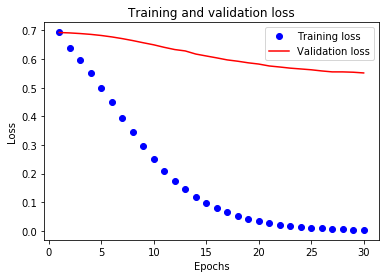

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [10]:
score = model.evaluate(X_test, y_test)
print(score)

400/400 [==============================] - 0s 180us/step
[0.5627283751964569, 0.7124999761581421]


In [11]:
from keras.layers import SimpleRNN, LSTM

model = Sequential()
model.add(Embedding(max_words, 32))
#model.add(SimpleRNN(32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, 
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2)

Train on 1280 samples, validate on 320 samples
Epoch 1/30
1280/1280 [==============================] - 15s 11ms/step - loss: 0.6926 - acc: 0.5156 - val_loss: 0.6917 - val_acc: 0.5688
Epoch 2/30
1280/1280 [==============================] - 10s 8ms/step - loss: 0.6848 - acc: 0.6680 - val_loss: 0.6876 - val_acc: 0.6062
Epoch 3/30
1280/1280 [==============================] - 10s 8ms/step - loss: 0.6589 - acc: 0.7594 - val_loss: 0.6708 - val_acc: 0.6156
Epoch 4/30
1280/1280 [==============================] - 9s 7ms/step - loss: 0.6057 - acc: 0.7453 - val_loss: 0.6570 - val_acc: 0.6250
Epoch 5/30
1280/1280 [==============================] - 9s 7ms/step - loss: 0.5388 - acc: 0.8234 - val_loss: 0.6244 - val_acc: 0.6719
Epoch 6/30
1280/1280 [==============================] - 12s 9ms/step - loss: 0.4874 - acc: 0.8219 - val_loss: 0.6198 - val_acc: 0.7188
Epoch 7/30
1280/1280 [==============================] - 11s 9ms/step - loss: 0.4481 - acc: 0.9062 - val_loss: 0.5457 - val_acc: 0.7656
Epoch 8/3

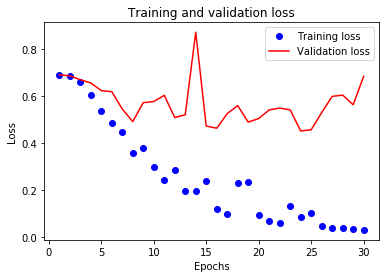

In [14]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

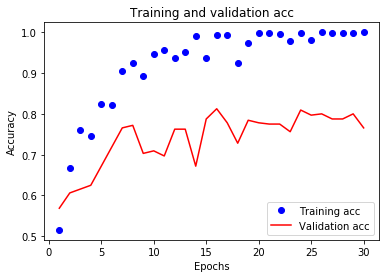

In [15]:
history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [16]:
score = model.evaluate(X_test, y_test)
print(score)

400/400 [==============================] - 2s 4ms/step
[0.6672368836402893, 0.762499988079071]


#### 문제점: train set의 크기가 너무 작다
해결방안: train set을 충분히 늘리거나, pre-trained embedding vector를 사용

### pre-trained embedding을 사용

In [19]:
glove_dir = './glove.6B/'
import os
import numpy as np

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Num of word vectors:', len(embeddings_index))

Num of word vectors: 400000


In [20]:
# 처음 데이터를 생성할 때 사용한 tokenizer에서 word_index를 추출
# 이 word_index에 맞게 glove로부터 해당하는 word vector를 가져옴
word_index = tokenizer.word_index
len(word_index)

43296

In [21]:
#embedding matrix를 생성: word_index에서 max_words 만큼의 단어에 대해 glove의 embeddings_index를 추출하여 matrix 생성
#추출한 matrix는 embedding 층의 weight로 고정해서 사용함

embedding_dim = 100 # glove의 vector dimension
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [22]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers import SimpleRNN, LSTM

model = Sequential()
model.add(Embedding(max_words, embedding_dim))
#model.add(SimpleRNN(32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False #값을 고정
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,017,057
Trainable params: 17,057
Non-trainable params: 1,000,000
_________________________________________________________________


In [24]:
from keras import optimizers
#rmsprop = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0) #default lr은 0.001
#rmsprop = optimizers.RMSprop(lr=0.005) #default lr은 0.001
adam = optimizers.Adam(lr=0.005) #default lr은 0.001

# pre-train이 되어 있으므로 적은 수의 test set으로도 학습이 가능
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, 
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2) 
#model.save_weights('pre_trained_glove_model.h5')

Train on 1280 samples, validate on 320 samples
Epoch 1/30
1280/1280 [==============================] - 15s 12ms/step - loss: 0.7040 - acc: 0.4945 - val_loss: 0.6872 - val_acc: 0.5562
Epoch 2/30
1280/1280 [==============================] - 14s 11ms/step - loss: 0.6781 - acc: 0.5813 - val_loss: 0.6797 - val_acc: 0.5813
Epoch 3/30
1280/1280 [==============================] - 15s 11ms/step - loss: 0.6632 - acc: 0.6062 - val_loss: 0.6625 - val_acc: 0.6062
Epoch 4/30
1280/1280 [==============================] - 12s 10ms/step - loss: 0.6299 - acc: 0.6625 - val_loss: 0.6557 - val_acc: 0.6094
Epoch 5/30
1280/1280 [==============================] - 13s 10ms/step - loss: 0.6270 - acc: 0.6484 - val_loss: 0.7524 - val_acc: 0.5469
Epoch 6/30
1280/1280 [==============================] - 12s 9ms/step - loss: 0.6336 - acc: 0.6500 - val_loss: 0.6599 - val_acc: 0.5969
Epoch 7/30
1280/1280 [==============================] - 11s 8ms/step - loss: 0.6225 - acc: 0.6719 - val_loss: 0.6320 - val_acc: 0.6531
Epo

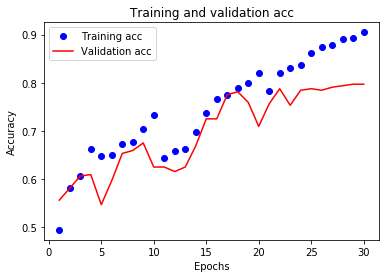

In [25]:
history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [26]:
score = model.evaluate(X_test, y_test)
print(score)

400/400 [==============================] - 2s 5ms/step
[0.5206716060638428, 0.7699999809265137]


### glove를 사용하지 않으면서 좀 더 정교한 모형을 사용하여 학습

+ optimizer를 정교하게 조정하고, regularizer를 추가

In [27]:
from keras.layers import SimpleRNN, LSTM
from keras import regularizers

model = Sequential()
model.add(Embedding(max_words, 32))
#model.add(SimpleRNN(32))
model.add(LSTM(32))
#model.add(Dense(32, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.1))) #0.01을 먼저 시도했음

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [28]:
from keras import optimizers
#adam = optimizers.Adam(lr=0.005) #default lr은 0.001
rmsprop = optimizers.RMSprop(lr=0.005) #default lr은 0.001

model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['acc']) 
#lr 조절 없고 l2=0.01일 때 test 0.775 나옴

history = model.fit(X_train, y_train, 
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2) 

Train on 1280 samples, validate on 320 samples
Epoch 1/30
1280/1280 [==============================] - 12s 10ms/step - loss: 0.8097 - acc: 0.5266 - val_loss: 0.7790 - val_acc: 0.5844
Epoch 2/30
1280/1280 [==============================] - 12s 10ms/step - loss: 0.8109 - acc: 0.6398 - val_loss: 0.7673 - val_acc: 0.5094
Epoch 3/30
1280/1280 [==============================] - 13s 10ms/step - loss: 0.7191 - acc: 0.6445 - val_loss: 0.7363 - val_acc: 0.5938
Epoch 4/30
1280/1280 [==============================] - 13s 10ms/step - loss: 0.6466 - acc: 0.7594 - val_loss: 0.7213 - val_acc: 0.5875
Epoch 5/30
1280/1280 [==============================] - 12s 10ms/step - loss: 0.5677 - acc: 0.8242 - val_loss: 0.6934 - val_acc: 0.6656
Epoch 6/30
1280/1280 [==============================] - 11s 9ms/step - loss: 0.4758 - acc: 0.8844 - val_loss: 0.6681 - val_acc: 0.7188
Epoch 7/30
1280/1280 [==============================] - 12s 9ms/step - loss: 0.4110 - acc: 0.9320 - val_loss: 0.7137 - val_acc: 0.6656
Epo

In [29]:
score = model.evaluate(X_test, y_test)
print(score)

400/400 [==============================] - 1s 3ms/step
[0.8489889550209045, 0.6899999976158142]
